### Cargo Librerias y datasets

In [1]:
import math
import numpy as np
import random
from scipy.stats import uniform
from scipy.stats import randint

import pandas as pd

pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_columns',200)

import copy
import joblib

In [2]:
from pathlib import Path
import sys

sys.path.append('../../data')
sys.path.append('../../')
PATH = Path('../../data/')

In [3]:
from lib import transformers, data, mvp_budget_utils

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,make_scorer,precision_score, recall_score, roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline,TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.svm import LinearSVR


from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA, NMF
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor #use RandomForestRegressor for regression problem
from sklearn.ensemble import GradientBoostingRegressor #For Regression

from sklearn.model_selection import cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold,GroupKFold,KFold

In [5]:
# from sklearn.datasets import load_svmlight_file
# from sklearn.linear_model import LinearRegression, LassoCV
# from sklearn import datasets
# from sklearn import preprocessing
# from sklearn import tree
# from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
# from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
# from sklearn import datasets, linear_model
# from sklearn.externals 


## Cargamos movies & movies gross
#### Movies lo cargamos para tener el ds a mano por si queremos agregar algo mas.

In [6]:
# Si quiero cargar todo
# movies_full = data.load_data(PATH)

# Si quiero cargar solo budget con gross (data vieja)
movies_gross = data.load_movie_gross(PATH)

# cargo info de budget con el scrapper (data nueva)
imdb_scrapper_budget = data.imdb_scrapper(PATH)

Dataset ya disponible


In [9]:
# creamos variable tconst para poder matchear (si queremos) con movies
movies_gross['tconst']=movies_gross.movie_imdb_link.apply(lambda x: x.replace('http://www.imdb.com/title/','').replace('/?ref_=fn_tt_tt_1',''))

In [10]:
#Renombro columna de director y year
# Esto lo hago para usar las funciones de los transformers ... 
# Si vemos que tiene sentido y suma, hacemos nuestra propia funcion, por el momento es test
movies_gross['startYear'] = movies_gross['title_year']
movies_gross['director']  = movies_gross['director_name']

## Data Cleanning

In [11]:
df_movies_gross= movies_gross.copy()

In [12]:
# me quedo con las peliculas que tengan un budget asignado, 
# y también con las que sean de 1970 (revisar el año) y con las que no esten duplicadas
# revisar el tipo de moneda de cada pais, porque me suena a que o son outliers o estan en otra moneda

from dateutil.parser import parse

df_movies_gross = df_movies_gross[~df_movies_gross.budget.isna()].copy()
df_movies_gross = df_movies_gross[df_movies_gross.title_year > 1990].copy()
df_movies_gross['tconst'] = df_movies_gross.movie_imdb_link.apply(lambda x: x.split('/')[4])
# df_movies_gross = df_movies_gross.drop_duplicates(df_movies_gross.columns[df_movies_gross.columns.isin(['tconst'])],
#                         keep='first')

### Chequeo el filtro

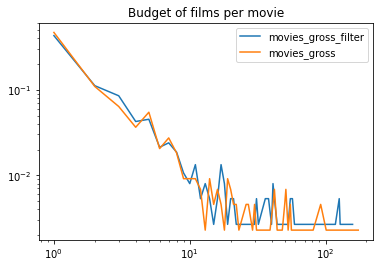

In [15]:
mvp_budget_utils.plot_budget_validation(df_movies_gross, movies_gross, True) #log_vars=True

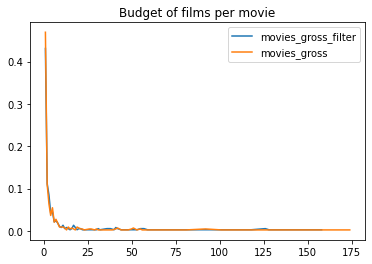

In [16]:
mvp_budget_utils.plot_budget_validation(df_movies_gross, movies_gross, False)

In [17]:
# cuanto representan las peliculas de USA 
(df_movies_gross.country == 'USA').sum() / len(df_movies_gross)

0.7679377822378324

In [18]:
df_usa_budget = df_movies_gross[df_movies_gross.country == 'USA'].copy()

### Analizo si me mueve la aguja tener solo US

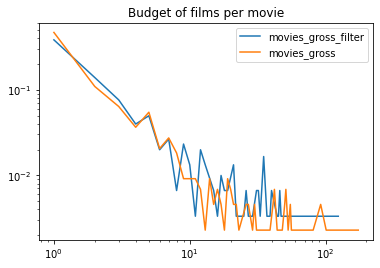

In [19]:
mvp_budget_utils.plot_budget_validation(df_usa_budget, movies_gross)

In [20]:
# Filtro columnas del df movie_gross y me quedo con las que pueden servir
df_movies_budget = df_usa_budget[['director', 'actor_1_name','actor_2_name', 'actor_3_name', 'genres', 'movie_title', 'movie_imdb_link', 'language', 'country', 'content_rating',
                                 'title_year', 'startYear', 'duration', 'num_critic_for_reviews', 'director_facebook_likes', 'actor_2_facebook_likes', 
                                 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes','facenumber_in_poster', 
                                 'num_user_for_reviews', 'imdb_score', 'tconst', 'budget']]
df_movies_budget.head(2)

,director,actor_1_name,actor_2_name,actor_3_name,genres,movie_title,movie_imdb_link,language,country,content_rating,title_year,startYear,duration,num_critic_for_reviews,director_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,imdb_score,tconst,budget
0,James Cameron,CCH Pounder,Joel David Moore,Wes Studi,Action|Adventure|Fantasy|Sci-Fi,Avatar,http://www.imdb.com/title/tt0499549/?ref_=fn_tt_tt_1,English,USA,PG-13,2009.0,2009.0,178.0,723.0,0.0,936.0,855.0,1000.0,886204,4834,0.0,3054.0,7.9,tt0499549,237000000.0
1,Gore Verbinski,Johnny Depp,Orlando Bloom,Jack Davenport,Action|Adventure|Fantasy,Pirates of the Caribbean: At World's End,http://www.imdb.com/title/tt0449088/?ref_=fn_tt_tt_1,English,USA,PG-13,2007.0,2007.0,169.0,302.0,563.0,5000.0,1000.0,40000.0,471220,48350,0.0,1238.0,7.1,tt0449088,300000000.0


## Definimos la función para dividir el ds en train, val y test


In [22]:
def load_budget_train_dev_test(df):

    X = df.loc[:,'title_year':'tconst'] #me quedo con train solo
#     X = df.loc[ : , df.columns != 'budget'] #me quedo con train solo
    y = df["budget"]  #var target y
    
    # Split en 80:20, esto es train y val
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=101)

    # AHora con el 0.875, tengo mi test, y finalmente me queda 70,20,10   (ver que 0.8 * 0.875 = 0.7)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.875, random_state=101)

    print("len(X): {} len(y): {} \nlen(X_train): {}, len(X_val): {}, len(X_test): \
    {} \nlen(y_train): {}, len(y_val): {}, len(y_test): {}".format(len(X), len(y),\
    len(X_train), len(X_val), len(X_test), len(y_train), len(y_val), \
    len(y_test))) 
    
#     return X_train.to_dict(orient='records'), X_val.to_dict(orient='records'), X_test.to_dict(orient='records'), y_train, y_val, y_test
    return X_train, X_val, X_test, y_train, y_val, y_test

### Definimos la función para entrenar los modelos


In [25]:
def train_models(pipeline, params, X,      y,     X_test,      y_test,       vars_target, pipe_label):

    # me quedo solo con las numericas
#     df_movies_budget.iloc[:,10:-2].head(2)
    X_test_= copy.deepcopy(X_test.loc[:,'title_year':'imdb_score'])

    #Params RS
    rs = RandomizedSearchCV(pipeline, param_distributions=params, refit=True,
                  scoring='neg_mean_squared_error', cv=5, n_jobs=-1, n_iter=10,random_state=42, verbose=0)
    d = []
#         rs.fit(X.iloc[:,5:-4].values, y[i].values)
    rs.fit(X.loc[:,'title_year':'imdb_score'].values, y.values)
    rs_model= rs.best_estimator_

    d.append({'pipe_label': pipe_label, 'target': vars_target[0], 'best_score_train': rs.best_score_,
              'best_score_test': rs_model.score(X_test_, y_test),

              'rmse_train': np.sqrt(mean_squared_error(y.values, rs_model.predict(X.loc[:,'title_year':'imdb_score'].values))),

              'rmse_test': np.sqrt(mean_squared_error(y_test.values, rs_model.predict(X_test_.values)))
             })
    joblib.dump(rs_model, '../../model_output/'+vars_target[0]+'_'+pipe_label+'_.pkl')

    out = pd.DataFrame(d)
    out[['pipe_label','target', 'best_score_train', 'best_score_test', 'rmse_train', 'rmse_test' ]].to_csv('../../prediction_output/results.csv', mode='a', header=True, index=False)

    return out

#### Filtramos los nan y los inf

In [23]:
# df_movies_budget.dropna(subset=['budget'])
# ds_filter = copy.deepcopy(df_movies_budget[~df_movies_budget.isin([np.nan, np.inf, -np.inf])])
ds_filter = copy.deepcopy(df_movies_budget)

ds_filter[ds_filter==np.inf]=np.nan
ds_filter.fillna(ds_filter.mean(), inplace=True)
# TODO falta sacar series y novelas y chinos

X_train, X_val, X_test, y_train, y_val, y_test = load_budget_train_dev_test(ds_filter)

len(X): 3061 len(y): 3061 
len(X_train): 2142, len(X_val): 613, len(X_test):     306 
len(y_train): 2142, len(y_val): 613, len(y_test): 306


#### Defino la class IdentityMatrix para aplicar en el pipeline

In [24]:
class IdentityTransformer(BaseEstimator,TransformerMixin):
    def transform(self, X, **transform_params):
        return X
    def fit(self, X, y=None, **fit_params):
        return self

#### Defino la función que inicializa los pipelines que quiero probar 

In [ ]:
def define_pipes():
    # creo estimadores para transformar data (2nd features)
    pipe1 = Pipeline([
            ('Pipe_StandardScaler', FeatureUnion([
                                    ('media', StandardScaler())
                                    ],n_jobs=-1)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42, verbose=0 ))
            ])

    pipe2 = Pipeline([
            ('Pipe_MinMaxScaler', FeatureUnion([
                                    ('range',MinMaxScaler()),
                                    ],n_jobs=-1)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42 ))
            ])
    
    pipe3 = Pipeline([
            ('IdentityTransformer', FeatureUnion([
                                    ('in', IdentityTransformer()),
                                    ],n_jobs=-1)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42 ))
            ])

    pipe4 = Pipeline([
            ('superPipe', FeatureUnion([
                                    ('in', IdentityTransformer()),
                                    ('pca', PCA(n_components=2)),
                                    ('nmf', NMF(init='random')),
                                    ("univ_select", SelectKBest(k=1)),
                                    ('range',MinMaxScaler()),
                                    ('media', StandardScaler())
                                    ],n_jobs=-1)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42 ))
            ])

    pipe5 = Pipeline([
            ('superPipe2', FeatureUnion([
                                    ('in', IdentityTransformer()),
                                    ('pca', PCA(n_components=2)),
                                    ('nmf', NMF(init='random')),
                                    ("univ_select", SelectKBest(k=1)),
                                    ('range',MinMaxScaler()),
                                    ('media', StandardScaler())
                                    ],n_jobs=-1)),
            ('feature_selection', SelectFromModel(LinearSVR(), threshold=None)),
            ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse',
                                                            n_jobs=-1,oob_score = 'TRUE', random_state=42 ))
            ])
    
    # params estimators+alg
    params = {

        # Para aprovechar el poder de RandomizedSearchCV, en lugar de pasarle parámetros fijos, 
        # se le pasan distribuciones de las cuales tomar los parámetros. Esa es la principal 
        # diferencia con GridSearch. 
            
        'RandomForestRegressor__max_features': ('log2', 'sqrt', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6),
        'RandomForestRegressor__n_estimators': randint(100, 1000),
        'RandomForestRegressor__max_depth': randint(1,20),
        'RandomForestRegressor__min_samples_leaf': randint(1,20),
        'RandomForestRegressor__min_samples_split':randint(1,20)
        
        
                
        # RandomForestRegressor params (si usáramos GridSearch)
        
        #'RandomForestRegressor__max_features': ('log2', 'sqrt', None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6),
        #'RandomForestRegressor__n_estimators': random.sample(range(100, 1000), 100),
        #'RandomForestRegressor__max_depth': range(1, 20),
        #'RandomForestRegressor__min_samples_leaf':range(1, 20),
        #'RandomForestRegressor__min_samples_split':range(1, 20)
    }
    
    return pipe1, pipe2, pipe3, pipe4, pipe5, params

In [ ]:
#Defino entonces los pipelines:

pipe1,pipe2, pipe3,pipe4, pipe5, params = define_pipes()
output={}


In [ ]:
### Entrenamos los pipes

In [ ]:
for pipe in (pipe1,pipe2, pipe3,pipe4, pipe5):
    print("pipelabel: ",str(pipe.steps[0][0]), "\n",pipe.named_steps,"\n")
    pipe_label=str(pipe.steps[0][0]) #get name pipe

    if repr(pipe_label) ==repr('superPipe') or repr(pipe_label) ==repr('superPipe2'):
        print('\npipe_label : ',pipe_label,'\n')
    output =train_models(pipe, params,  X_train, y_train, X_val, y_val, ["budget"], str(pipe_label+'_budget_pred'))

## Con los pkl, elijo el mejor de los modelos (viendo el excel), y predigo.

In [ ]:
loaded_model1  = joblib.load('../../model_output/budget_superPipe2_budget_pred_.pkl')

In [ ]:
output=copy.deepcopy(ds_filter)
output['budget_pred'] = loaded_model1.predict(ds_filter.loc[:,'title_year':'imdb_score'])  # este es el entregable
output[['tconst', 'budget','budget_pred']].to_csv("../../prediction_output/"+"budget"+"_salida.csv")

### A mí me gusta el R2, porque es más directo de comparar, aunque en términos prácticos no sepas por cuánta guita le estás errando.

In [ ]:
print('R2 score: ', r2_score(output['budget'],output['budget_pred']))